In [2]:
import glob
import json
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Check MW - MSD genre distribution

In [77]:
target_fn = '/hdd/data/mxmmsdrecsys_tids_all.txt'
targets = set([
    l.strip('\n') for l
    in open(target_fn).readlines()
])

In [91]:
sid2tid = {}
with open('/hdd/data/unique_tracks.txt') as f:
    for line in f:
        tid, sid = line.split('<SEP>')[:2]
        sid2tid[sid] = tid

In [7]:
fns = glob.glob('/hdd/data/millionsongdataset_echonest/*/*.json')

In [87]:
msd2spotify = []
with tqdm(total=len(fns), ncols=80) as p:
    for fn in fns:
        d = json.load(open(fn))
        data = {
            song['id']: {
                t['id']:t['foreign_id']
                for t in song['tracks']
                if t['foreign_id'][:4] == 'spot'
            }
            for song in d['response']['songs']
        }
        msd2spotify.append(data)
        p.update(1)

100%|████████████████████████████████| 999056/999056 [01:27<00:00, 11401.33it/s]


In [127]:
n_songs = [len(s) for s in msd2spotify]
n_tracks = [len(list(s.values())[0]) if len(s) > 0 else 0 for s in msd2spotify]

In [128]:
Counter(n_songs)

Counter({1: 793116, 0: 205940})

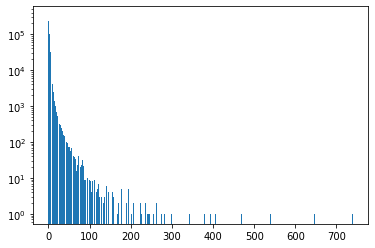

In [129]:
plt.bar(range(max(n_tracks)+1), np.bincount(n_tracks))
plt.yscale('log')

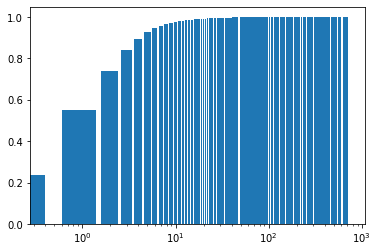

In [130]:
plt.bar(range(max(n_tracks)+1), np.cumsum(np.bincount(n_tracks) / len(n_tracks)))
plt.xscale('log')

In [119]:
msd2spotify_survived = [
    tuple(songs.items())[0] for songs in [
        {
            s:t for s, t in songs.items()
            if (s in sid2tid) and (sid2tid[s] in targets)
        }
        for songs in msd2spotify
    ] if len(songs) > 0
]

In [141]:
msd2spotify_triplet = []
for sid, tracks in msd2spotify_survived:
    for tid, spot_id in tracks.items():
        msd2spotify_triplet.append((sid, tid, spot_id))
        
msd2spotify_ids_set = set([r[2].split(':')[-1] for r in msd2spotify_triplet])

In [146]:
survived_mw_spotify_ids = []
mw_meta_fn = '/hdd/data/mw_spotify_labels.tab'
with open(mw_meta_fn, encoding="utf8", errors='ignore') as f:
    for line in f:
        i, mw_al_id, mw_tr_id, mw_spot_id, mw_genre, _, _ = line.strip('\n').split('\t')
        if mw_spot_id in msd2spotify_ids_set:
            survived_mw_spotify_ids.append((i, mw_al_id, mw_tr_id, mw_spot_id, mw_genre))

In [ ]:
genre_hist = sorted(
    Counter([r[4] for r in survived_mw_spotify_ids]).items(),
    key=lambda r:-r[1]
)

In [172]:
len(survived_mw_spotify_ids)

103073

## Result

1. Number of samples filtered down from 332,674 to 103,073. I expect there must be some bias introduced to the data from the Dutch music market (~preference? demend?)
2. It will be further filtered down to about 75% of it (~75,000) due to the missing data of MxM database and the non-English entries
3. Genre distribution looks like this. (top 30 genres / taking account ~65% of the data, meaning the other 35% of data mapped to more granular genres ~2.6k)

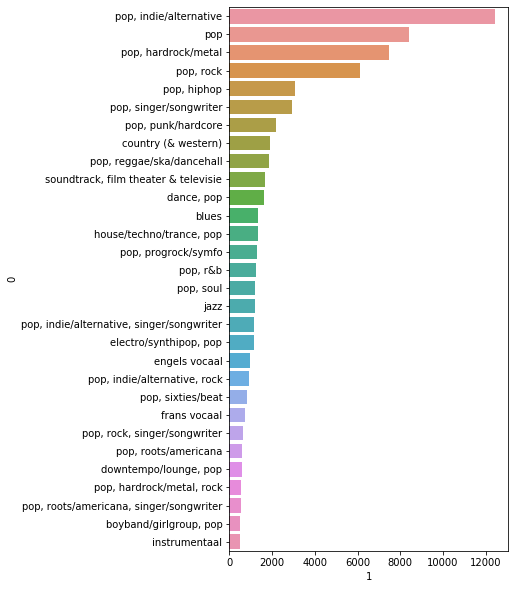

In [170]:
df = pd.DataFrame(genre_hist)
fig, ax = plt.subplots(1,1,figsize=(5, 10))
sns.barplot(x=df[1][:30], y=df[0][:30], data=df, orient='h', ax=ax)

# Checking MSD - TagTraum genre set

In [183]:
msd2tagtraum = []
with open('/hdd/data/msd_tagtraum_cd2c.cls') as f:
    for i, line in enumerate(f):
        if i > 6:
            tid, genre = line.strip('\n').split('\t')
            msd2tagtraum.append((tid, genre))

In [188]:
tagtraum_targets = (
    set([r[0] for r in msd2tagtraum])
    .intersection(set(targets))
)
len(tagtraum_targets)

109274

In [194]:
tagtraum_genres = sorted(
    Counter([r[1] for r in msd2tagtraum
     if r[0] in tagtraum_targets]).items(),
    key=lambda r: -r[1]
)
tagtraum_genres = pd.DataFrame(tagtraum_genres)

## Result

1. Number of samples filtered down from 332,674 to 109,274. Filtering bias is from the platform where the researchers choose to pull out the relevant info for the genre mapping.
2. Again, it will be further filtered down to about 75% of it (~75,000) due to the missing data of MxM database and the non-English entries
3. Genre distribution looks like this.

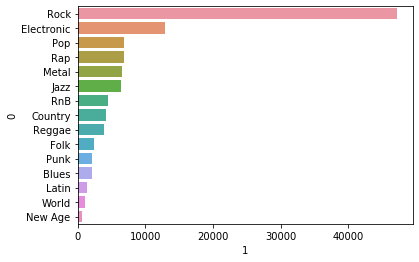

In [195]:
sns.barplot(x=1, y=0, data=tagtraum_genres)